In [177]:
from __future__ import annotations

import sys
import numpy as np

sys.path.append('BO/')

import functools
from copy import copy, deepcopy
from typing import Callable, Dict, List, Union

import numpy as np
from joblib import Parallel, delayed
from scipy.stats import rankdata
from sklearn.decomposition import PCA
from sklearn.metrics import mean_absolute_percentage_error, r2_score

from bayes_optim.acquisition import acquisition_fun as AcquisitionFunction
from bayes_optim.bayes_opt import BO, ParallelBO
from bayes_optim.search_space import RealSpace, SearchSpace
from bayes_optim.solution import Solution
from bayes_optim.surrogate import GaussianProcess, RandomForest, trend
from bayes_optim.utils import timeit
import matplotlib.pyplot as plt
%matplotlib inline

plt.style.use('default')
plt.style.use('seaborn-v0_8-darkgrid')
plt.style.use('seaborn-v0_8-poster')


### Task 1

Implement lines 5, 6, 7, 8 and 11 of Algorithm 1 from [1].
Calculate the weights for rescaling according to the formula proposed in [1]: $$ \widetilde{w}_i := \log(N) - \log(r(i)), w_i := \widetilde{w}_i \cdot \left( \sum_{i=1}^N \widetilde{w}_i \right) ^ {-1}, $$
where $N$ is the number of considered points $X$, and $r(i)$ is the rank of the $i$-th point. If the objective function $F$ is minimized then the rank $r(i)$ of a point $X_{r(i)}$ is defined as follows: $$ r: \N \cap [1, N] \to \N \cap [1, N] : F(X_{r(i)}) \le F(X_{r(j)}) \text{ iff } i \le j. $$

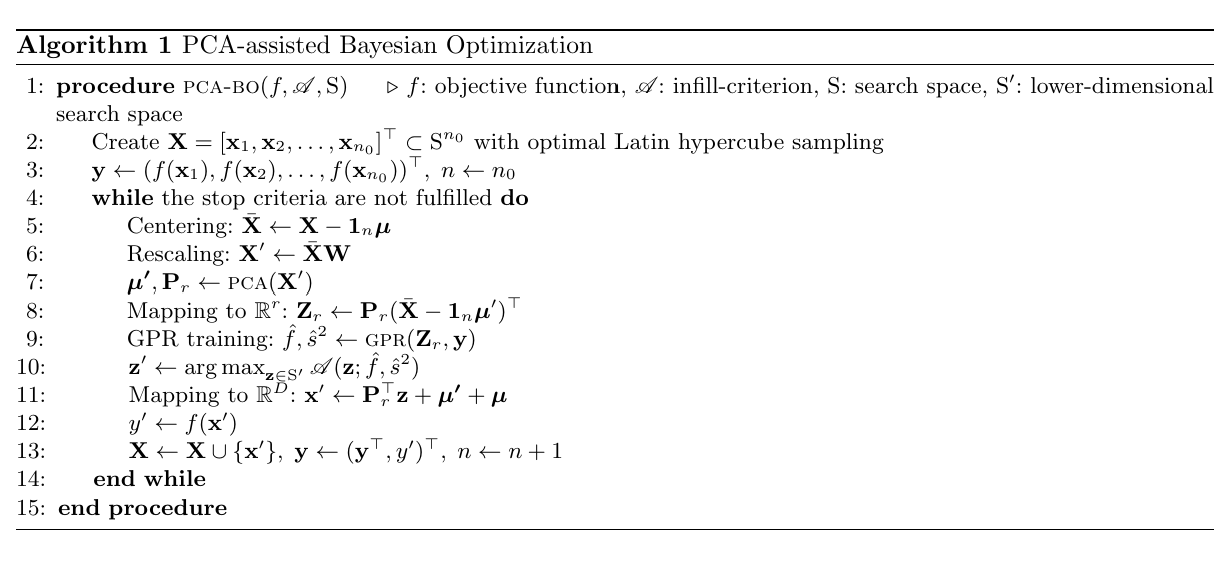

References.

[1] Raponi E. et al. High dimensional Bayesian optimization assisted by principal component analysis //Parallel Problem Solving from Nature–PPSN XVI: 16th International Conference, PPSN 2020, Leiden, The Netherlands, September 5-9, 2020, Proceedings, Part I 16. – Springer International Publishing, 2020. – С. 169-183.

In [178]:
class LinearTransform(PCA):
    def __init__(self, minimize: bool = True, **kwargs):
        super().__init__(**kwargs)
        self.minimize = minimize
        self.X_scaled = []

    def fit(self, X: np.ndarray, y: np.ndarray) -> LinearTransform:
        """center the data matrix and scale the data points with respect to the objective values

        Parameters
        ----------
        data : Solution
            the data matrix to scale

        Returns
        -------
        Tuple[np.ndarray, np.ndarray]
            the scaled data matrix, the center data matrix, and the objective value
        """
        # TODO
        self.center = X.mean(axis=0)
        X_centered = X - self.center
        y_ = -1 * y if not self.minimize else y

        # set different weights
        r = rankdata(y_)
        N = len(y_)
        w = np.log(N) - np.log(r)

        w /= np.sum(w)
        self.X_scaled = X_centered * w.reshape(-1, 1)
        ## 
        # self.X_scaled = X.copy() # change
        # apply pca to the scaled data
        return super().fit(self.X_scaled)  # fit the PCA transformation on the scaled data matrix

    def transform(self, X: np.ndarray) -> np.ndarray:
        # transform the centered data matrix
        # TODO
        return super().transform(X - self.center)  

    def fit_transform(self, X: np.ndarray, y: np.ndarray) -> np.ndarray:
        # Reduces dimensionality of the data
        # TODO
        self.fit(X, y)
        return self.transform(X)

    def inverse_transform(self, X: np.ndarray) -> np.ndarray:
        # Restores the infill points X to the original domain
        # TODO
        if not hasattr(self, "components_"):
            return X
        return super().inverse_transform(X) + self.center


Use the following code to check your implementation.

(200, 1)


Text(0.5, 1.0, 'Mapped')

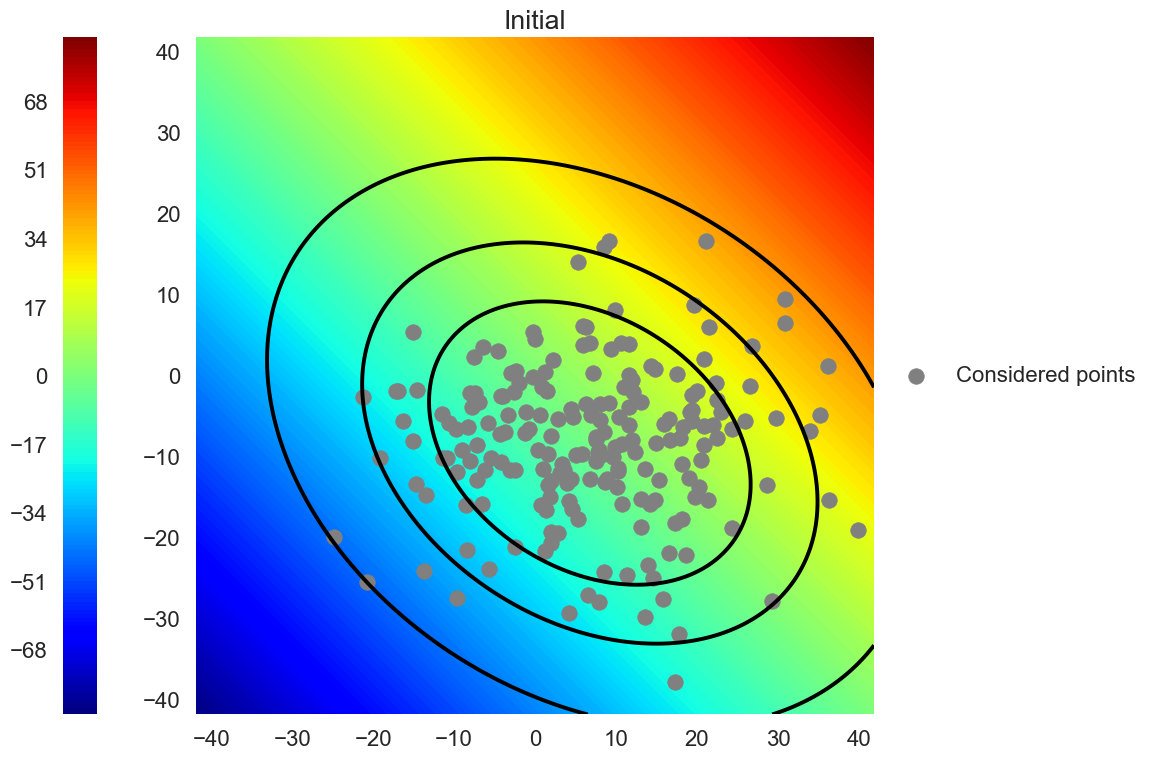

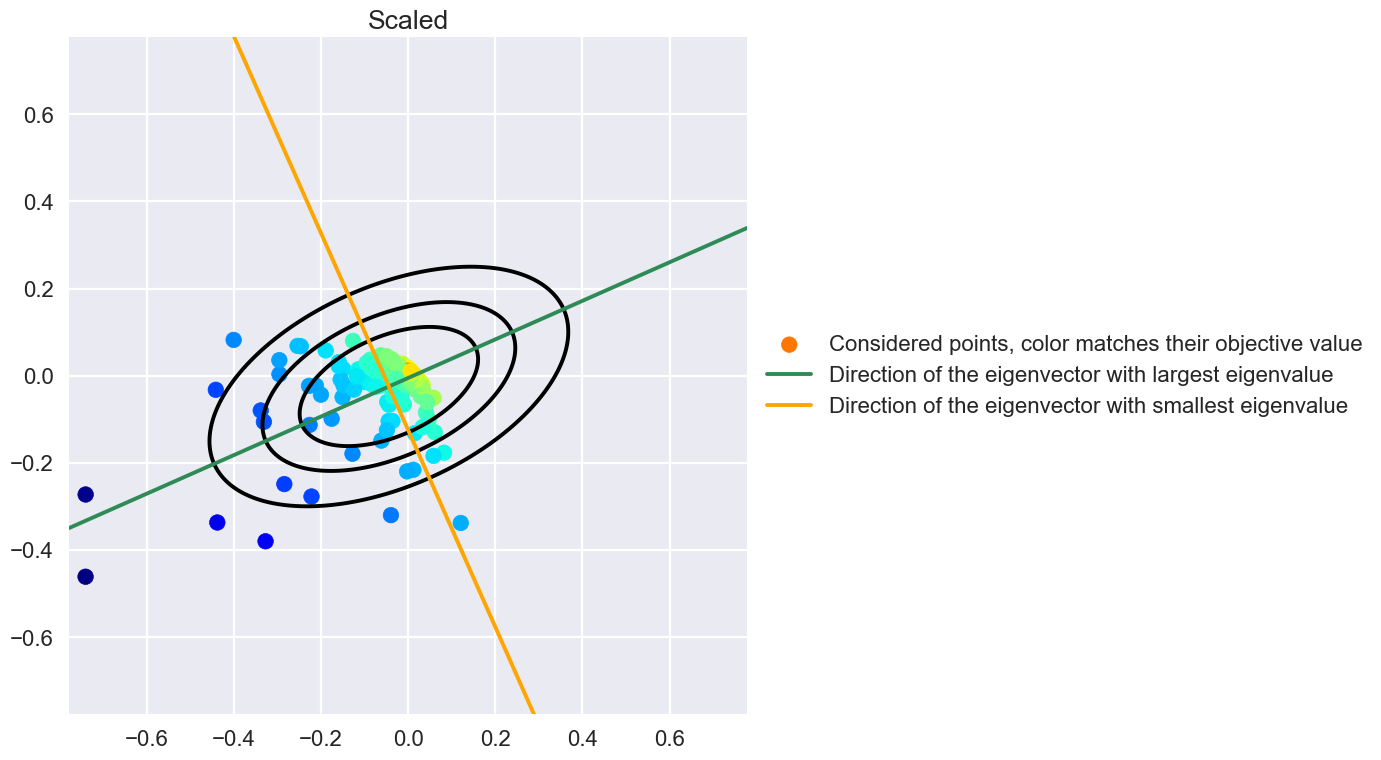

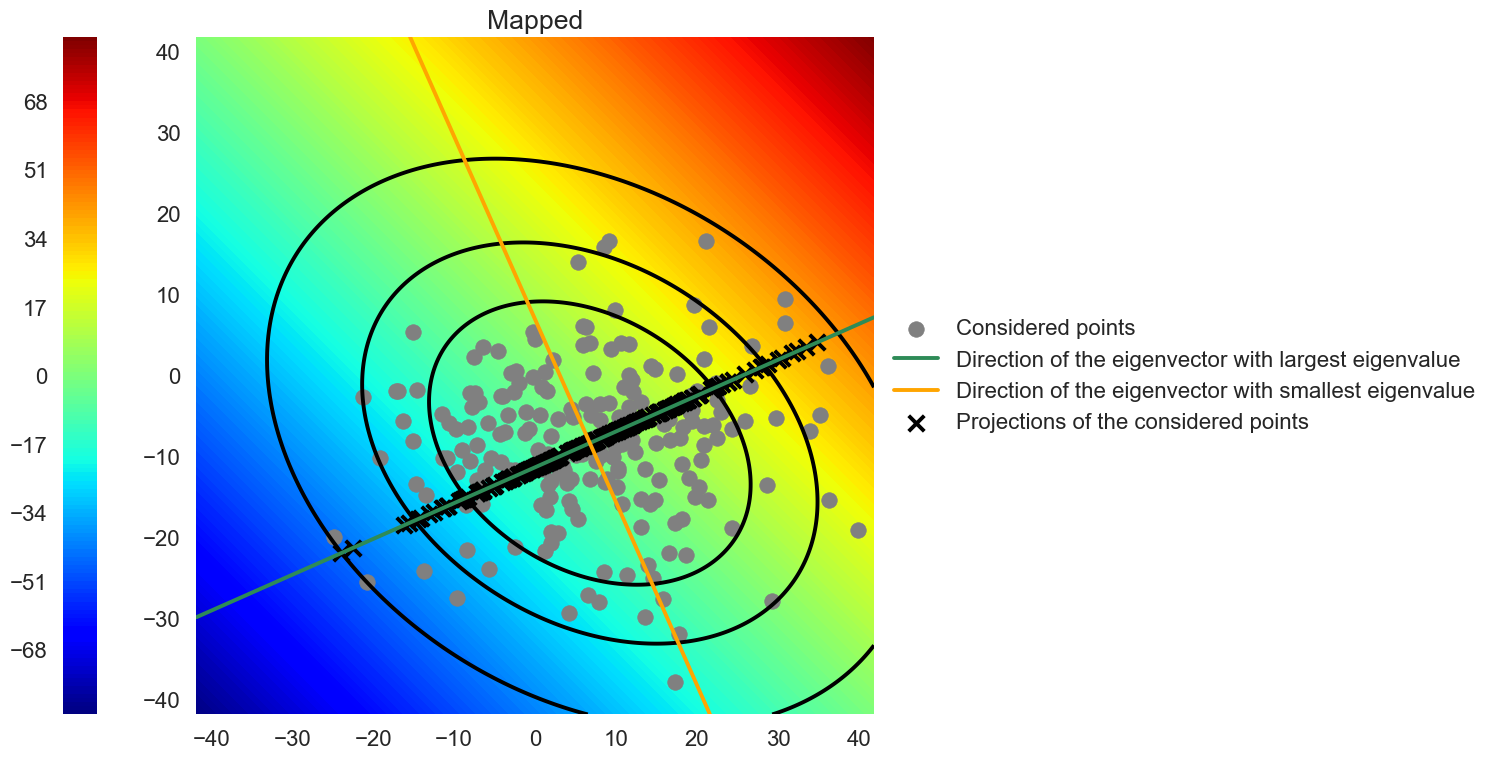

In [179]:
import matplotlib.pyplot as plt


X, Y = [], []
color=[]
np.random.seed(10)
mycmap=plt.cm.jet
F = lambda x: x[0] + x[1]
for i in range(200):
    x = [5, -8] + np.array([[1.3,0],[0,1]]) @ np.random.normal(0, 10, 2)
    X.append(x)
    Y.append(F(x))
X, Y = np.array(X), np.array(Y)

color = mycmap((Y - Y.min())/(Y.max() - Y.min()))
_pca = LinearTransform(n_components=0.75, svd_solver="full", minimize=True)

XT = _pca.fit_transform(X, Y)
print(XT.shape)


def plt_set_limits(data):
    xmin, xmax = min(data[:, 0]), max(data[:, 0])
    ymin, ymax = min(data[:, 1]), max(data[:, 1])
    xabsmax = max(abs(xmin), abs(xmax))
    yabsmax = max(abs(ymin), abs(ymax))
    absmax = max(xabsmax, yabsmax)
    xmin, xmax = -absmax - 0.05*absmax, absmax + 0.05*absmax
    ymin, ymax = -absmax - 0.05*absmax, absmax + 0.05*absmax
    plt.xlim(xmin, xmax)
    plt.ylim(ymin, ymax)
    return xmin, xmax, ymin, ymax


def computeXYZ(xlim, ylim, data, f=None):
    x = np.linspace(*xlim, 500)
    y = np.linspace(*ylim, 500)
    X, Y = np.meshgrid(x, y)
    Z = X.copy()
    if not f:
        c = data.mean(axis=0)
        M = np.linalg.inv(data.T @ data)
        f = lambda w: (w.T - c) @ M @ (w - c)
    for i in range(len(Z)):
        for j in range(len(Z[i])):
            Z[i][j] = f(np.array([X[i][j], Y[i][j]]))
    return X, Y, Z


fig = plt.figure()
ax = fig.gca()
ax.set_aspect('equal', adjustable='box')
xmin, xmax, ymin, ymax = plt_set_limits(X)
Xs, Ys, Zs = computeXYZ((xmin, xmax), (ymin, ymax), X)
v = lambda p: -2*np.log(1-p)
levels = [v(0.6827/140), v(0.6827/70), v(0.6827/35)]
plt.contour(Xs, Ys, Zs, levels=levels, colors='k')
Xs, Ys, Zs = computeXYZ((xmin, xmax), (ymin, ymax), None, F)
plt.contourf(Xs, Ys, Zs, levels=len(X), cmap=mycmap, alphas=0.5)
plt.colorbar(orientation='vertical', location='left')
plt.scatter(X[:, 0], X[:, 1], c='grey', label='Considered points') 
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title('Initial')

fig = plt.figure()
ax = fig.gca()
ax.set_aspect('equal', adjustable='box')
G = (_pca.X_scaled.T ) @ (_pca.X_scaled )
evals, evecs = np.linalg.eigh(G)
xmin, xmax, ymin, ymax = plt_set_limits(_pca.X_scaled)
plt.scatter(_pca.X_scaled[:, 0], _pca.X_scaled[:, 1], c=color, label='Considered points, color matches their objective value') 
Xs, Ys, Zs = computeXYZ((xmin, xmax), (ymin, ymax), _pca.X_scaled)
v = lambda p: -2*np.log(1-p)
levels = [v(0.6827/100), v(0.6827/50), v(0.6827/25)]
plt.contour(Xs, Ys, Zs, levels=levels, colors='k')
x0, y0 = _pca.X_scaled.mean(axis=0)
plt.axline(xy1=(x0, y0), xy2=[x0,y0]+evecs[:, 1], label='Direction of the eigenvector with largest eigenvalue', color='seagreen')
plt.axline(xy1=(x0, y0), xy2=[x0,y0]+evecs[:, 0], label='Direction of the eigenvector with smallest eigenvalue', color='orange')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title('Scaled')

fig = plt.figure()
ax = fig.gca()
ax.set_aspect('equal', adjustable='box')
x0, y0 = X.mean(axis=0)
P = np.array([x @ evecs[:, 1] * evecs[:, 1] for x in X]) + np.array([x0,y0]) @ evecs[:, 0] * evecs[:, 0]
xmin, xmax, ymin, ymax = plt_set_limits(X)
Xs, Ys, Zs = computeXYZ((xmin, xmax), (ymin, ymax), X)
v = lambda p: -2*np.log(1-p)
levels = [v(0.6827/140), v(0.6827/70), v(0.6827/35)]
plt.contour(Xs, Ys, Zs, levels=levels, colors='k')
Xs, Ys, Zs = computeXYZ((xmin, xmax), (ymin, ymax), None, F)
plt.contourf(Xs, Ys, Zs, levels=len(X), cmap=mycmap, alphas=0.5)
plt.colorbar(orientation='vertical', location='left')
plt.scatter(X[:, 0], X[:, 1], c='grey', label='Considered points') 
plt.axline(xy1=(x0,y0), xy2=[x0,y0]+evecs[:,1], label='Direction of the eigenvector with largest eigenvalue', color='seagreen')
plt.axline(xy1=(x0,y0), xy2=[x0,y0]+evecs[:, 0], label='Direction of the eigenvector with smallest eigenvalue', color='orange')
plt.scatter(P[:, 0], P[:, 1], c='k', marker='x', label='Projections of the considered points')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title('Mapped')


### Task 2

By now you should understand what happens inside PCA-BO. 
You are given the rest of the code for PCA-BO algorithm.
It uses the class `LinearTransformation` that you implemented earlier.
Your task is to propose two function for extreme cases: 
1) Function which PCA-BO optimizes very well;
2) Function which PCA-BO can optimize worse that BO.

In [180]:
def penalized_acquisition(x, acquisition_func, bounds, pca, return_dx):
    bounds_ = np.atleast_2d(bounds)
    # map back the candidate point to check if it falls inside the original domain
    x_ = pca.inverse_transform(x)
    idx_lower = np.nonzero(x_ < bounds_[:, 0])[0]
    idx_upper = np.nonzero(x_ > bounds_[:, 1])[0]
    penalty = -1 * (
        np.sum([bounds_[i, 0] - x_[i] for i in idx_lower])
        + np.sum([x_[i] - bounds_[i, 1] for i in idx_upper])
    )

    if penalty == 0:
        out = acquisition_func(x)
    else:
        if return_dx:
            # gradient of the penalty in the original space
            g_ = np.zeros((len(x_), 1))
            g_[idx_lower, :] = 1
            g_[idx_upper, :] = -1
            # get the gradient of the penalty in the reduced space
            g = pca.components_.dot(g_)
            out = (penalty, g)
        else:
            out = penalty
    return out

In [181]:
class PCABO(BO):
    """Dimensionality reduction using Principle Component Decomposition (PCA)

    References

    [RaponiWB+20]
        Raponi, Elena, Hao Wang, Mariusz Bujny, Simonetta Boria, and Carola Doerr.
        "High dimensional bayesian optimization assisted by principal component analysis."
        In International Conference on Parallel Problem Solving from Nature, pp. 169-183.
        Springer, Cham, 2020.

    """

    def __init__(self, n_components: Union[float, int] = None, **kwargs):
        super().__init__(**kwargs)
        if self.model is not None:
            self.logger.warning(
                "The surrogate model will be created automatically by PCA-BO. "
                "The input argument `model` will be ignored"
            )
        assert isinstance(self._search_space, RealSpace)
        self.__search_space = deepcopy(self._search_space)  # the original search space
        self._pca = LinearTransform(n_components=n_components, svd_solver="full", minimize=self.minimize)

    @staticmethod
    def _compute_bounds(pca: PCA, search_space: SearchSpace) -> List[float]:
        C = np.array([(l + u) / 2 for l, u in search_space.bounds])
        radius = np.sqrt(np.sum((np.array([l for l, _ in search_space.bounds]) - C) ** 2))
        C = C - pca.mean_ - pca.center
        C_ = C.dot(pca.components_.T)
        return [(_ - radius, _ + radius) for _ in C_]

    def _create_acquisition(self, fun=None, par=None, return_dx=False, **kwargs) -> Callable:
        acquisition_func = super()._create_acquisition(
            fun=fun, par={} if par is None else par, return_dx=return_dx, **kwargs
        )
        # TODO: make this more general for other acquisition functions
        # wrap the penalized acquisition function for handling the box constraints
        return functools.partial(
            penalized_acquisition,
            acquisition_func=acquisition_func,
            bounds=self.__search_space.bounds,  # hyperbox in the original space
            pca=self._pca,
            return_dx=return_dx,
        )

    def pre_eval_check(self, X: List) -> List:
        """Note that we do not check against duplicated point in PCA-BO since those points are
        sampled in the reduced search space. Please check if this is intended
        """
        if isinstance(X, np.ndarray):
            X = X.tolist()
        return X

    @property
    def xopt(self):
        if not hasattr(self, "data"):
            return None
        fopt = self._get_best(self.data.fitness)
        self._xopt = self.data[np.where(self.data.fitness == fopt)[0][0]]
        return self._xopt

    def ask(self, n_point: int = None) -> List[List[float]]:
        return self._pca.inverse_transform(super().ask(n_point))

    def tell(self, new_X, new_y):
        self.logger.info(f"observing {len(new_X)} points:")
        for i, x in enumerate(new_X):
            self.logger.info(f"#{i + 1} - fitness: {new_y[i]}, solution: {x}")

        index = np.arange(len(new_X))
        if hasattr(self, "data"):
            index += len(self.data)
        # convert `new_X` to a `Solution` object
        new_X = self._to_geno(new_X, index=index, n_eval=1, fitness=new_y)
        self.iter_count += 1
        self.eval_count += len(new_X)

        new_X = self.post_eval_check(new_X)  # remove NaN's
        self.data = self.data + new_X if hasattr(self, "data") else new_X
        # re-fit the PCA transformation
        X = self._pca.fit_transform(np.array(self.data), self.data.fitness)
        bounds = self._compute_bounds(self._pca, self.__search_space)
        # re-set the search space object for the reduced (feature) space
        self._search_space = RealSpace(bounds)
        # update the surrogate model
        self.update_model(X, self.data.fitness)
        # self.logger.info(f"xopt/fopt:\n{self.xopt}\n")

    def update_model(self, X: np.ndarray, y: np.ndarray):
        # NOTE: the GPR model will be created since the effective search space (the reduced space
        # is dynamic)
        dim = self._search_space.dim
        bounds = np.asarray(self._search_space.bounds)
        self.model = GaussianProcess(
            mean=trend.constant_trend(dim),
            corr="matern",
            thetaL=1e-3 * (bounds[:, 1] - bounds[:, 0]),
            thetaU=1e3 * (bounds[:, 1] - bounds[:, 0]),
            nugget=1e-6,
            noise_estim=False,
            optimizer="BFGS",
            wait_iter=3,
            random_start=max(10, dim),
            likelihood="concentrated",
            eval_budget=100 * dim,
        )

        _std = np.std(y)
        y_ = y if np.isclose(_std, 0) else (y - np.mean(y)) / _std

        self.fmin, self.fmax = np.min(y_), np.max(y_)
        self.frange = self.fmax - self.fmin

        self.model.fit(X, y_)
        y_hat = self.model.predict(X)

        r2 = r2_score(y_, y_hat)
        MAPE = mean_absolute_percentage_error(y_, y_hat)
        self.logger.info(f"model r2: {r2}, MAPE: {MAPE}")


Here is how you can run the `PCABO` algorithm.

In [189]:
np.random.seed(123)
dim = 30
lb, ub = -5, 5


def obj_function_example(x):
    x = np.asarray(x)
    return sum((np.arange(1, dim + 1) * x) ** 2)


def best_pcabo_function(x):
    # TODO
    return sum(np.arange(1, len(x) + 1) * x) + 1 # Linear


def worst_pcabo_function(x):
    # TODO
    return 10*len(x) + sum(xi**2 - 10*np.cos(2*np.pi*xi) for xi in x) # Rastrigin


space = RealSpace([lb, ub]) * dim
opt = PCABO(
    search_space=space,
    obj_fun=best_pcabo_function,
    DoE_size=5,
    max_FEs=40,
    verbose=True,
    n_point=1,
    n_components=0.75,
    acquisition_optimization={"optimizer": "BFGS"},
)
print(opt.run())

10/29/2024 12:03:51,957 - [PCABO (1724378071968).INFO] -- iteration 0 starts...
10/29/2024 12:03:51,962 - [PCABO (1724378071968).INFO] -- asking 5 points (using DoE):
10/29/2024 12:03:51,963 - [PCABO (1724378071968).INFO] -- #1 - [-1.577655534478489, 3.0795271942083726, 0.6330341661363335, -3.95966937634468, 0.524059066296898, 3.152879507997641, -3.8884969488874, 0.4336285560857345, -1.643353598723118, 0.7950251390931804, 1.5508029681680018, -4.403548499673509, -1.8652659899425608, 2.1256620091101492, -2.563729598790439, -4.381340836379296, 3.258711953294153, 0.8764012152034963, -3.205449158407264, 4.413461023412694, -4.284837106879248, 0.8942023185910442, 1.4763646327875382, -1.4451196263268686, -3.3519739499036385, 4.7846808954713556, 2.8969615020352535, -2.431516344468335, -4.23955868062925, -4.404341680004444]
10/29/2024 12:03:51,963 - [PCABO (1724378071968).INFO] -- #2 - [3.650257116253945, 1.922099051717571, -1.1608600423339928, 0.7498277395475306, 3.3577874461188255, 0.749326079

### Solution of Task 2

Linear funciton is one of the perfect functions for PCA-BO because it satisfies the main assumption: there is a linear manifold that contains low-cost solutions.

Rastrigin function does not satisfy this assumption. Moreover, when sampled points are projected to the smaller dimensional linear manifold, the smaller dimensional funciton becomes very ill-conditioned. Therefore, the Gaussian process is complicated and has many local optima. Hence, finding infill point is very difficult.